<a href="https://colab.research.google.com/github/anirudhkumar29/db-A-Discontinuity-bounded-Search-for-Kinodynamic-Mobile-Robot-Motion-Planning/blob/main/Lab2_rmp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Configuration space** **exploration**

---



Path found with 108 steps.


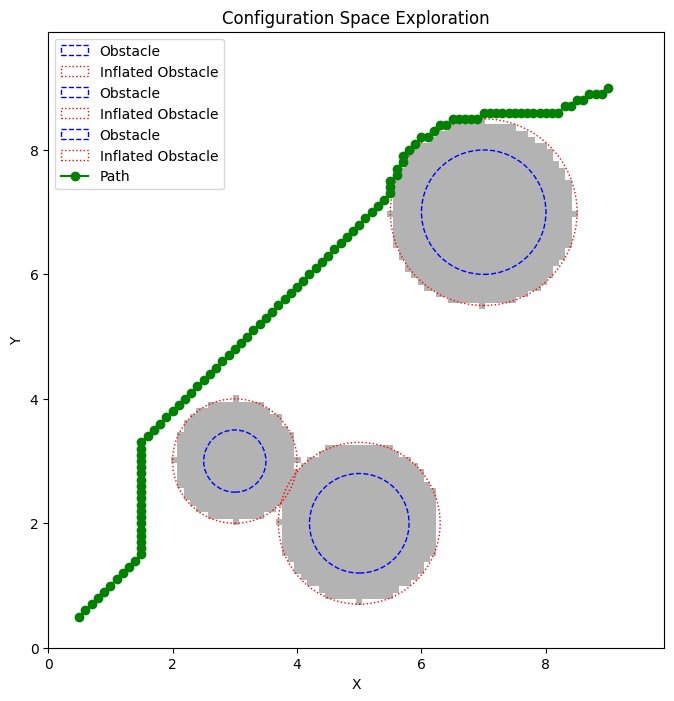

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq



# Utility and Geometry Functions

def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def inflate_obstacle(obstacle, robot_radius):
    """Inflate a circular obstacle by robot's radius."""
    center, radius = obstacle['center'], obstacle['radius']
    return {'center': center, 'radius': radius + robot_radius}

def point_in_circle(point, circle):
    """Return True if point is inside circle."""
    return distance(point, circle['center']) <= circle['radius']



# A* Search on a Grid (2D)

def astar(grid, start, goal):
    """
    A* search on a grid.
    grid: 2D numpy array where 0 indicates free space and 1 indicates obstacle.
    start, goal: (row, col) indices.
    Returns path as list of grid indices.
    """
    rows, cols = grid.shape
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: distance(start, goal)}

    neighbors = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]

    while open_set:
        current = heapq.heappop(open_set)[1]
        if current == goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor] == 1:
                    continue
                tentative_g = g_score[current] + distance(current, neighbor)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None



# Configuration Space Exploration

def create_configuration_space(width, height, obstacles, robot_radius, resolution=0.1):
    """
    Create a grid for the configuration space.
    width, height: dimensions of the workspace.
    obstacles: list of obstacles in the form {'center': (x, y), 'radius': r}.
    robot_radius: radius of the circular robot.
    resolution: size of each grid cell.
    Returns:
     - grid: 2D numpy array, 0 is free and 1 is occupied.
     - x_vals, y_vals: arrays representing grid coordinates.
    """
    # Determine grid size
    x_vals = np.arange(0, width, resolution)
    y_vals = np.arange(0, height, resolution)
    grid = np.zeros((len(y_vals), len(x_vals)), dtype=int)

    # Inflate obstacles for configuration space
    inflated_obs = [inflate_obstacle(obs, robot_radius) for obs in obstacles]

    # Mark grid cells as occupied if within any inflated obstacle
    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            point = (x, y)
            for obs in inflated_obs:
                if point_in_circle(point, obs):
                    grid[i, j] = 1
                    break
    return grid, x_vals, y_vals




# Visualization

def visualize_cspace(grid, x_vals, y_vals, path, obstacles, robot_radius):
    plt.figure(figsize=(8,8))
    # Plot the configuration space grid (occupied cells)
    plt.imshow(grid, origin='lower', extent=(x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]),
               cmap='Greys', alpha=0.3)

    # Plot original obstacles and inflated obstacles
    for obs in obstacles:
        # Original obstacle
        circle1 = plt.Circle(obs['center'], obs['radius'], color='blue', fill=False, linestyle='--', label='Obstacle')
        plt.gca().add_patch(circle1)
        # Inflated obstacle for C-space
        inflated = inflate_obstacle(obs, robot_radius)
        circle2 = plt.Circle(inflated['center'], inflated['radius'], color='red', fill=False, linestyle=':', label='Inflated Obstacle')
        plt.gca().add_patch(circle2)

    # Plot the computed path (convert grid indices back to coordinates)
    if path is not None:
        coords = [(x_vals[j], y_vals[i]) for i, j in path]
        xs, ys = zip(*coords)
        plt.plot(xs, ys, marker='o', color='green', label='Path')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Configuration Space Exploration')
    plt.legend(loc='best')
    plt.xlim(0, x_vals[-1])
    plt.ylim(0, y_vals[-1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()




# Main Simulation Function

def simulate_configuration_space():
    # Define workspace dimensions
    width, height = 10, 10
    # Define circular obstacles in the workspace
    obstacles = [
        {'center': (3, 3), 'radius': 0.5},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 2), 'radius': 0.8}
    ]
    # Define robot parameters: here, a circular robot of given radius
    robot_radius = 0.5

    # Create configuration space grid
    grid, x_vals, y_vals = create_configuration_space(width, height, obstacles, robot_radius, resolution=0.1)

    # Convert start and goal positions to grid indices
    start = (0.5, 0.5)
    goal = (9, 9)
    # Find nearest grid indices for start and goal
    def to_index(p, x_vals, y_vals):
        x, y = p
        j = np.argmin(np.abs(x_vals - x))
        i = np.argmin(np.abs(y_vals - y))
        return (i, j)
    start_idx = to_index(start, x_vals, y_vals)
    goal_idx = to_index(goal, x_vals, y_vals)

    # Run A* search on the grid
    path = astar(grid, start_idx, goal_idx)
    if path is None:
        print("No path found in configuration space.")
    else:
        print("Path found with", len(path), "steps.")

    # Visualize the results
    visualize_cspace(grid, x_vals, y_vals, path, obstacles, robot_radius)

if __name__ == "__main__":
    simulate_configuration_space()
